In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.signal as signal

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

# functions for KDE fits and GMM models

In [2]:
def get_peak_locations_from_KDE_fit(data, kde_bandwidth, find_peaks_wave_width_range, plot=True):
    ''' Performs a KDE fit and then uses scipy.signal.find_peaks_cwt to get peaks.
        The KDE bandwith parameter is critical, and 0.025 seems appropriate for OD700 data that isn't very widely
        distributed (is only between 0 and 1). 
        If it feels like you are missing many peak calls, decrease the bandwith. If it feels
        like you are having too many peak calls, increase the bandwith. 
        
        Don't change the bandwith without good reason, but one bandwidth will not be appropriate for all data
        
        more discussion of bandwidth and kde found here:
            #explanation of what it is and what parameters exist
        https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28
        https://mathisonian.github.io/kde/
            #implementations
        https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
        
        
        Additionally, the widths given for the wavelets (i think) used in the wavelet convolution peak finder
        are critical as well, they should cover the approximate possible widths of your peaks. This is as critical
        as the bandwidth parameter in the kde and will affect the accuracy of peak finding. If your kde bandwidth
        produces a smooth enough kde function, you can probably just use a simpler function like scipy.signal.find_peaks
        that just finds all local maxima by comparing values. Haven't tested the simpler algorithm yet.
        
        '''
                        #critical param, fiddle with it to avoid oversmoothing (too large)
                        #or undersmoothing (too small) and just getting the distribution back
                        #think of this like adjusting histogram bin size
    kde = KernelDensity(bandwidth=kde_bandwidth, kernel='gaussian')

    kde.fit(data[:, None]);

    #no points in our OD700 data exceed value 1, so it is unnecessary to score values far outside of that
    #doing so will probably ruin your peak estimation
    x_est = np.linspace(0,1.0,1000)

    log_dens = kde.score_samples(x_est[:,None])

    #Use the SciPy function to get the KDE peaks
                                                #critical param. if too small, will pick up "peaks" that are tiny or not
                                                #really there. If too large, will be very innacurate.
    peak_inds = signal.find_peaks_cwt(log_dens, find_peaks_wave_width_range, min_snr=1)

    means_init = []
    
    for peak_ind in peak_inds:
        means_init.append(x_est[peak_ind])
    
        #plot the KDE and peaks so you can check
    if plot==True:
        fig, ax = plt.subplots(figsize=(7,5))

        ax.plot(x_est, np.exp(log_dens), color='r', linewidth=3)
        ax.hist(data, density=True, color='purple');
        for m in means_init:
            ax.axvline(m, color='dodgerblue', linewidth=3, linestyle='-.')
    else:
        fig = None
    
    
    return means_init, fig

In [3]:
def fit_GMM_KDE(data, peaks): 
    """Generate a Gaussian mixture model from the output
    of a Gaussian Kernel Density Estimation. 
    
    Outputs the mean of the on peak, fraction on, mean of the off peak, 
    and fraction off. This version of the code assumes all cells not in the on peak are off!
    This is obviously only a good assumption for uni/bimodal data. If you have multimodal data,
    do not use this code."""
    
    #since you're passing a series instead of an array, convert to an array in format that Gaussian Mixture likes
    data_arr = data.values.reshape(len(data), 1)

    #peaks are passed as a list, so make them an array in proper format
    peaks = np.array(peaks).reshape(len(peaks), 1)
    
    #create the GMM with components equal to number of peaks found in your KDE fit, with initial means equal
    #to the peaks you founs
    opt_gmm = GaussianMixture(n_components = len(peaks) , means_init = peaks).fit(data_arr)  

    #built in method to predict the gaussian to which each data point belongs
    labels = opt_gmm.predict(data_arr)
    labels = np.ravel(labels.reshape(len(labels), 1))

    means = opt_gmm.means_
    
    #this df contains each measurement value and the gaussian it is associated with.
    #it also preserves the original index to you can put these assignments back into the full dataset
    #you can use this to pull out the measurements that fall into the desired gaussian for gating.
    df = pd.DataFrame({'value': np.ravel(data_arr), 'which_gaussian': labels})
    
    df['newindex'] = data.index
    df = df.set_index('newindex').rename_axis(None)
        
        
    return df, means

In [4]:
def assign_gmmpeak_kdefit (data, kde_bandwidth, find_peaks_wave_width_range, show_plots=True):
    
    peaks, fig = get_peak_locations_from_KDE_fit(data, kde_bandwidth, find_peaks_wave_width_range, show_plots)
    
    assignment, new_means = fit_GMM_KDE(data, peaks)
    
    if show_plots == True:
        ax = fig.get_axes()[0]
        
        #just a list that should be too long so you can subsample it later. The number of peaks can't exceed this len
        colors = ['orange', 'g', 'b', 'gold']

        #put a vertical dashed line at the new mean after GMM fitting
        #put a rugplot color coded by the gaussian to which each value is assigned
        for i in range(len(new_means)):
            d = assignment.loc[assignment['which_gaussian'] == i, 'value']
            ax.eventplot(positions=d, color=colors[i], linelengths=0.5, lineoffsets=0, linewidths=0.3)
            ax.axvline(new_means[i], color='k', linestyle = '--', linewidth=3)
            
        return assignment, new_means, peaks, fig

# get data

In [14]:
directory = 'Z:/Reed/Projects/lab misc/echo_cfu_count/'

file = '20200130 stored 1536 echo cfu.xlsx'

In [15]:
d = pd.read_excel(directory + file, sheet_name=None)

In [16]:
d.keys()

odict_keys(['Plate 1 - t0', 't0', 'Plate 2 - te', 'te', 'Plate 3 - tef', 'tef', 't0_tidy', 'te_tidy', 'tef_tidy', 'tall_tidy', 'IDs', 'Exp'])

In [17]:
df = d['tall_tidy']

In [18]:
df.head()

,cell,row,col,time,dil,plate,OD700,CFP,YFP,RFP
0,2c1r,A,1,0,10,1,0.401,2536,89,1406
1,2c1r,A,2,0,10,1,0.378,1838,91,1390
2,2c1r,A,3,0,10,1,0.634,32354,139,1662
3,2c1r,A,4,0,10,1,0.609,31674,135,1582
4,2c1r,A,5,0,10,1,0.593,28726,141,1729


## take out a condition to test

In [112]:
#if you just want to take one plate, give the appropriate thing here
plate = 3

#if you want to take the whole data set
everything=True

#if you want to do subconditions
subcond = False

cell = '2c1y'
time = 0
dil = 10000

#what measurement type are you looking at
meas = 'OD700'

In [113]:
# your options are subcondition (T/F), everything (T/F) or just a plate, no other things are currently possible
# so the else statement can be to get a plate

if subcond == True:
    #select just the data you want
    i1 = df['cell'] == cell
    i2 = df['time'] == time
    i3 = df['dil'] == dil

    i = i1 & i2 & i3
    
    sub = df.loc[i, meas]
    
elif everything == True:
    #get all the data of the measurement type
    sub = df.loc[:, meas]
    
else:
    #depending on the experiment, you will have to edit this line to get one plate
    i = df['plate'] == plate
    
    sub = df.loc[i, meas]

In [114]:
sub.head()

0    0.401
1    0.378
2    0.634
3    0.609
4    0.593
Name: OD700, dtype: float64

In [115]:
# sub = sub**3

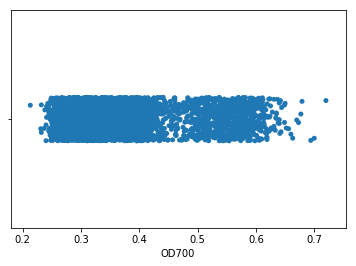

In [116]:
ax = sns.stripplot(x=sub)

# do the estimating and fitting

In [123]:
#critical parameters for kde and peak detection, will vary depending on absolute values and distribution of data

#0.025 is small enough for data with low absolute value and relatively tight distribution (like OD700), but still smooths
kde_bandwidth = 0.025

#the range here should over the expected widths of your peaks
find_peaks_wavelet_width_range = np.arange(0.1, 0.5, step=0.1)

C:\Users\geeze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Number of peaks/gaussians/means GMM finds:  2


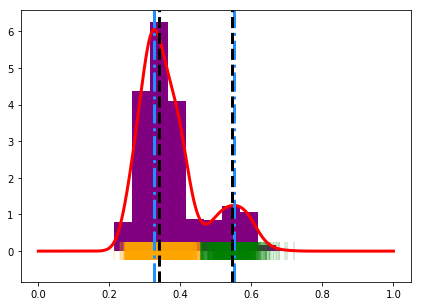

In [124]:
assignment, new_means, peaks, fig = assign_gmmpeak_kdefit(sub, kde_bandwidth, find_peaks_wavelet_width_range)
print('Number of peaks/gaussians/means GMM finds: ', len(new_means))

### pause, do you think the assignment pictured above is good? if so proceed, if not, adjust your params

In [125]:
#update the full dataset with your "gate" for counting. This will just update the indices run in this plate or 
#subsection of data you did. So this can be run iteratively to fill the dataset
if 'which_gaussian' in df.columns:
    df.loc[assignment.index, ['value', 'which_gaussian']] = assignment[['value', 'which_gaussian']]
else:
    #this will only happen once, before df has been updated at all
    df = df.join(assignment)

In [126]:
df

,cell,row,col,time,dil,plate,OD700,CFP,YFP,RFP,OD700_peak,OD700_peak,value,which_gaussian
0,2c1r,A,1,0,10,1,0.401,2536,89,1406,0.0,0,0.401,0
1,2c1r,A,2,0,10,1,0.378,1838,91,1390,0.0,0,0.378,0
2,2c1r,A,3,0,10,1,0.634,32354,139,1662,1.0,1,0.634,1
3,2c1r,A,4,0,10,1,0.609,31674,135,1582,1.0,1,0.609,1
4,2c1r,A,5,0,10,1,0.593,28726,141,1729,1.0,1,0.593,1
5,2c1r,A,6,0,10,1,0.626,30950,146,1757,1.0,1,0.626,1
6,2c1r,A,7,0,10,1,0.412,1689,74,1156,0.0,0,0.412,0
7,2c1r,A,8,0,10,1,0.582,28025,140,1688,1.0,1,0.582,1
8,2c1r,A,9,0,10,1,0.600,29011,141,1606,1.0,1,0.600,1
9,2c1r,A,10,0,10,1,0.575,28835,139,1697,1.0,1,0.575,1


# reformat pretty and save

In [127]:
if everything == True:
    bulk = '_BULK'
else:
    bulk = ''

df = df.drop(columns='value').rename(columns={'which_gaussian' : '{}{}_peak'.format(meas,bulk)})

In [128]:

    
df.to_csv(directory + 'all_tidy_{}{}_gated.csv'.format(meas, bulk))

# now reload the data and determine CFU counts

In [129]:
d = pd.read_excel(directory + file, sheet_name=None)

In [130]:
d.keys()

odict_keys(['Plate 1 - t0', 't0', 'Plate 2 - te', 'te', 'Plate 3 - tef', 'tef', 't0_tidy', 'te_tidy', 'tef_tidy', 'tall_tidy', 'counts', 'IDs', 'Exp'])

In [131]:
df = d['tall_tidy']

In [132]:
counts = d['counts']

In [133]:
counts.head()

,cell,time,dil
0,2c1r,0,10
1,2c1r,0,100
2,2c1r,0,1000
3,2c1r,0,10000
4,1c2r,0,10


## use the counts ID info to get plates and count them

In [134]:
from itertools import product

In [135]:
#get the columns in the dataset that contain the peak assignments
assignments_to_count = [x for x in df.columns if 'peak' in x]
#make the new column names you want
labels = [x.rstrip('_peak') for x in assignments_to_count]

In [136]:
#get all the unique conditions to iterate over
cells = counts['cell'].unique()
times = counts['time'].unique()
dils = counts['dil'].unique()

#get all the combinations
conds = list(product(cells, times, dils))

In [137]:
for name, label in zip(assignments_to_count, labels):


    for cond in conds:
        cell, time, dil = cond

        #indexing for the gated data itself
        i1 = df['cell'] == cell
        i2 = df['time'] == time
        i3 = df['dil'] == dil

        #indexing for the aggregate data
        c1 = counts['cell'] == cell
        c2 = counts['time'] == time
        c3 = counts['dil'] == dil

        #slices to take
        i = i1 & i2 & i3
        c = c1 & c2 & c3
        
        #some of these combinations don't exist, just skip them
        if i.any():
            num_off = sum(df.loc[i, name] == 0)
            num_tot = len(df.loc[i, name])
            
            counts.loc[c, '{}_off'.format(label)] = num_off / num_tot
            
        else:
            pass

In [138]:
counts.head()

,cell,time,dil,OD700_off,OD700_BULK_off
0,2c1r,0,10,0.218750,0.218750
1,2c1r,0,100,0.843750,0.854167
2,2c1r,0,1000,0.989583,0.989583
3,2c1r,0,10000,1.000000,1.000000
4,1c2r,0,10,0.583333,0.583333


## do the transformation to cfu/mL

In [139]:
from math import log as ln

In [140]:
for c in [x+'_off' for x in labels]:
    #get the column of interest plus the dilutions
    #replace 0 with nan since log cant deal with zero
    frac_empty = counts[c].replace(0, np.nan)
    #dilution column
    d = counts['dil']
    
    #-ln of fractions that are empty since this is the simplified calculation of lambda in poisson distribution when the
    #outcome you're looking for is zero events
    nlog = -frac_empty.apply(ln)
    
    #multiply up the dilution factor and again by the conversion between vol shot and mL
                                #THIS VALUE NEEDS TO CHANGE IF VOLUME SHOT IS CHANGED
    cfu = nlog * d * (10**6 / 100)
        
    counts[c + '_cfumL'] = cfu

In [141]:
counts

,cell,time,dil,OD700_off,OD700_BULK_off,OD700_off_cfumL,OD700_BULK_off_cfumL
0,2c1r,0,10,0.218750,0.218750,1.519826e+05,1.519826e+05
1,2c1r,0,100,0.843750,0.854167,1.698990e+05,1.576289e+05
2,2c1r,0,1000,0.989583,0.989583,1.047130e+05,1.047130e+05
3,2c1r,0,10000,1.000000,1.000000,-0.000000e+00,-0.000000e+00
4,1c2r,0,10,0.583333,0.583333,5.389965e+04,5.389965e+04
5,1c2r,0,100,0.927083,0.927083,7.571182e+04,7.571182e+04
6,1c2r,0,1000,1.000000,1.000000,-0.000000e+00,-0.000000e+00
7,1c2r,0,10000,1.000000,1.000000,-0.000000e+00,-0.000000e+00
8,2c1y,0,10,0.083333,0.093750,2.484907e+05,2.367124e+05
9,2c1y,0,100,0.677083,0.687500,3.899609e+05,3.746934e+05


In [142]:
counts.to_csv(directory + 'cfu_counts.csv', index=False)